# Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import glob as gb
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score, recall_score
from hashlib import md5
print("Done")
s = 100

Done


# Read the training dataset

In [3]:
data = "C:\\Users\\Sigma\\archive\\train"
categorys = os.listdir(data) 
code, get_category = {} ,{}
for i, n in enumerate(categorys): 
    code[n] = i
    get_category[i] = n


In [4]:
def get_hash(path): return md5(path).hexdigest()

In [5]:
##### Read the images
x, y, duplicate, size, hash, dic = [], [], [], [], [], {}
for category in categorys:
    path = os.path.join(data, category)
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path,img))
        image_resize = cv2.resize(image, (s,s)) # resize it to be 100 * 100 *3
        image = image_resize / 255.0 # normalize the image
        x.append(list(image))
        y.append(code[category])
        h = get_hash(image)
        if h in hash: duplicate.append(((img, category), dic[h]))
        else: 
            hash.append(h)
            dic[h] = (img, category)
        size.append(image.shape)
x = np.array(x)
y = np.array(y)

# Dataset analysis and preprocessing

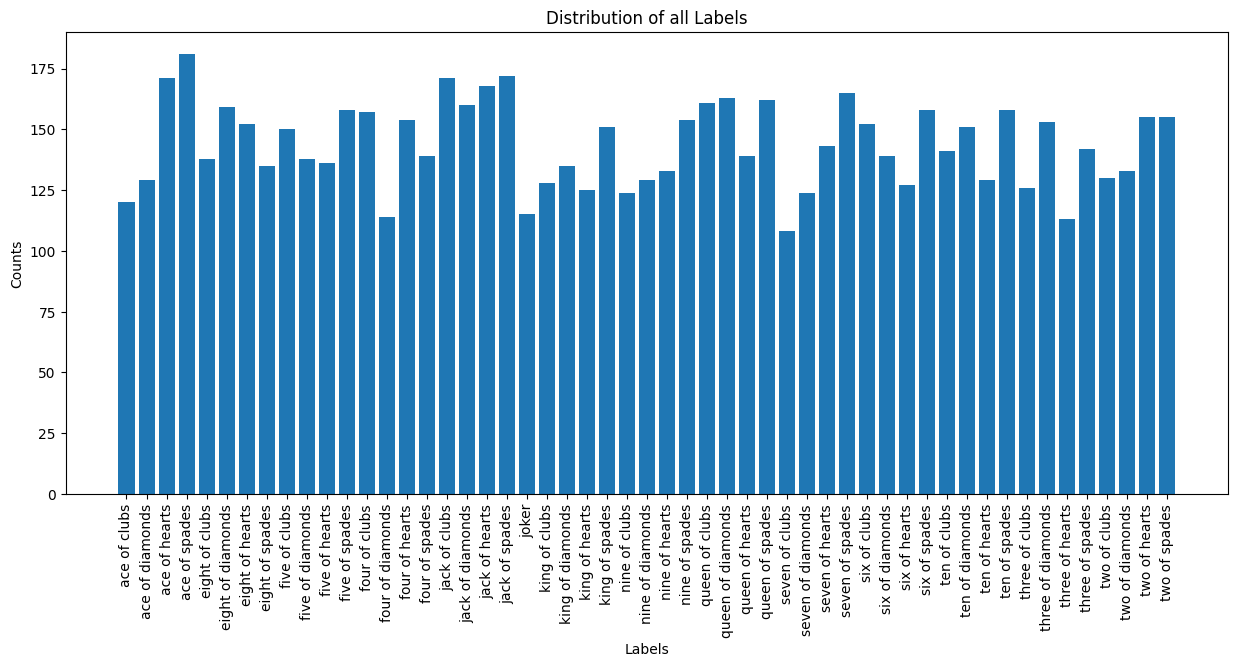

In [6]:
label_counts = {}
for label in y:
    if label in label_counts: label_counts[label] += 1
    else: label_counts[label] = 1

labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(15, 6))
plt.bar(categorys, counts)
plt.title('Distribution of all Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation = 90)  
plt.show()

2- Does our dataset have duplicated image?

In [7]:
duplicate

[(('120.jpg', 'four of spades'), ('127.jpg', 'four of clubs')),
 (('080.jpg', 'three of diamonds'), ('079.jpg', 'three of diamonds'))]

3- Does our dataset have label issues?

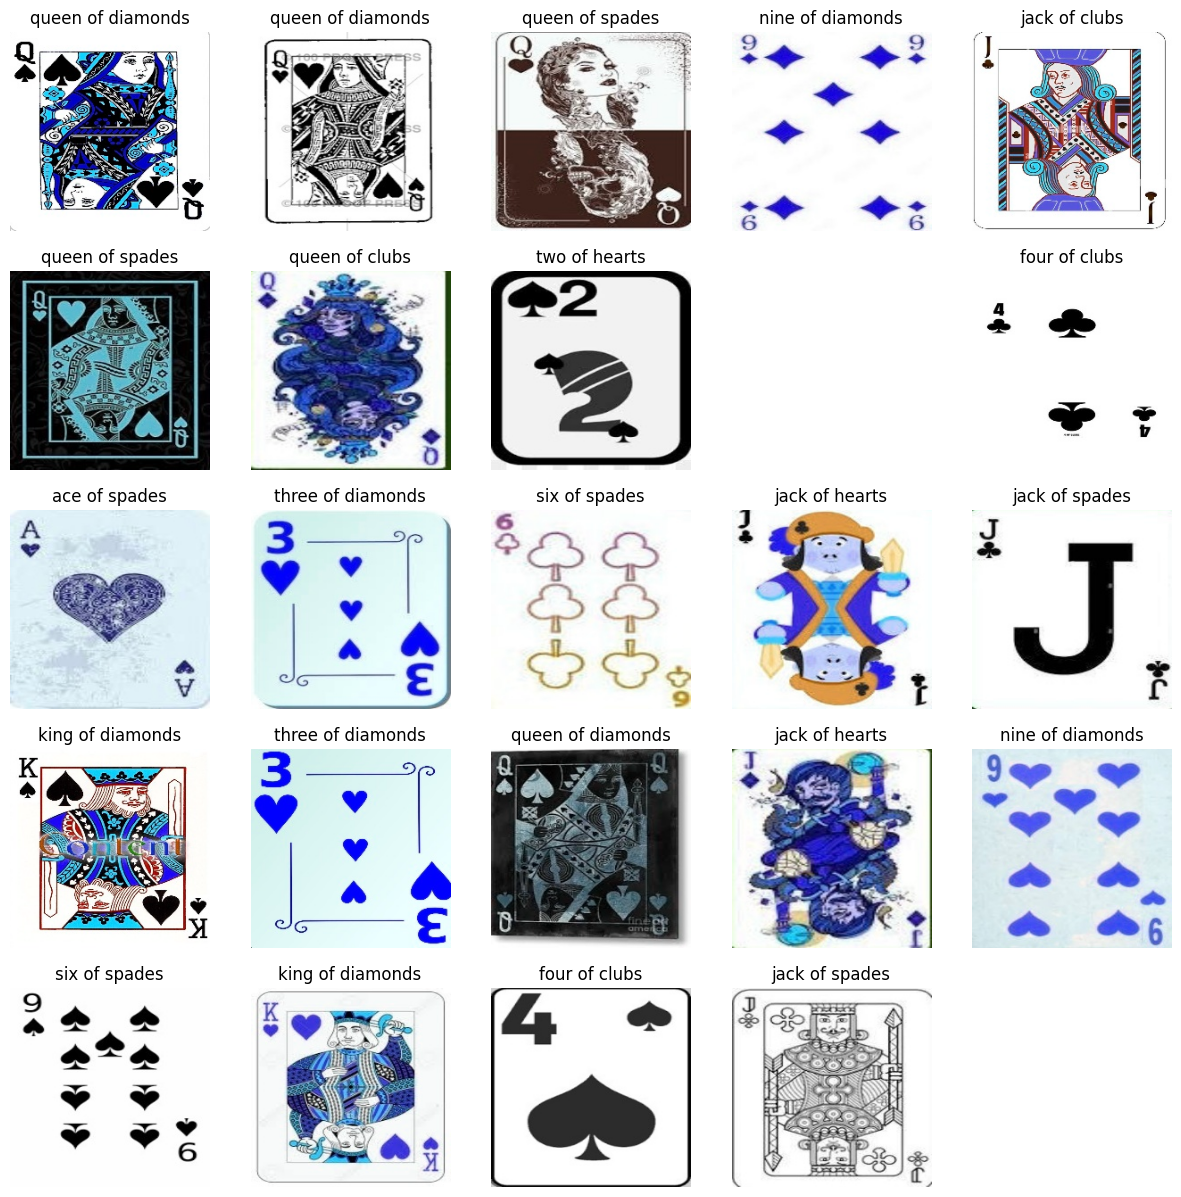

In [51]:
p = pd.read_csv('C:\\Users\\Sigma\\cl2.csv')
issues = []
issues = p[(p['cleanlab_action'] == 'auto-fix') | (p['cleanlab_action'] == 'exclude')]
issues_img = list(issues['image'])
issues_label = list(issues['label'])

plt.figure(figsize=(15, 15))
for n, i in enumerate(issues_img):
    if i != 'queen of diamonds/084.jpg':
        plt.subplot(5, 5, n+1)
        plt.imshow(cv2.imread(os.path.join('C:/Users/Sigma/archive/train',i)))
        plt.axis('off')
        plt.title(issues_label[n])

4- Does our dataset have outliers?

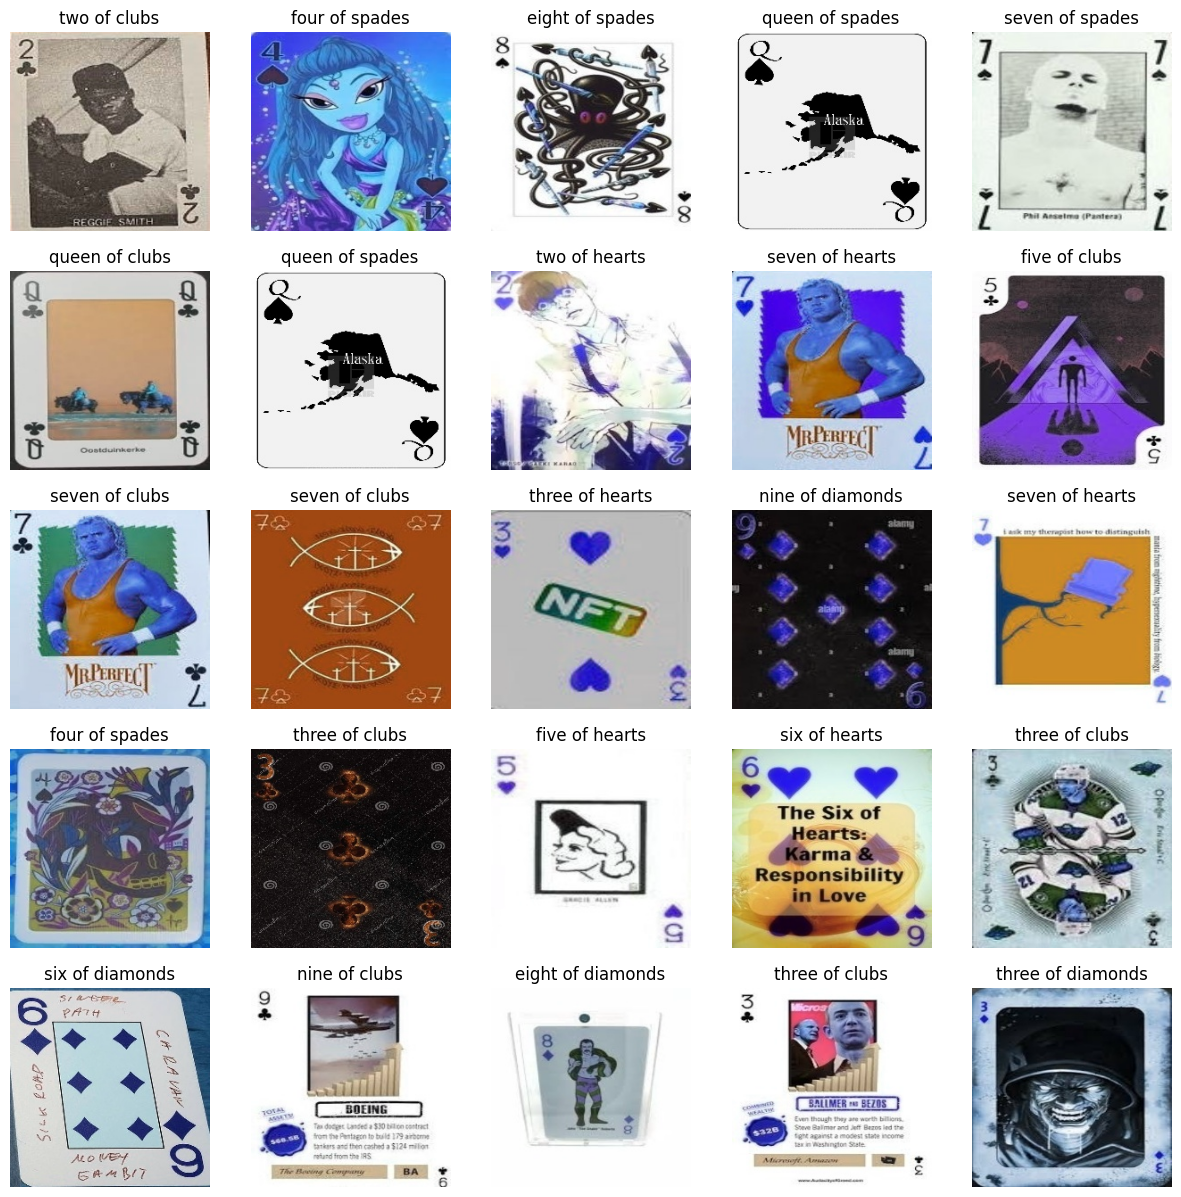

In [52]:
outlier = p[p['cleanlab_is_outlier'] == True]
out_img = list(outlier['image'])
out_label = list(outlier['label'])

plt.figure(figsize=(15, 15))
for n, i in enumerate(list(np.random.randint(0, len(out_img), 25))):
        plt.subplot(5, 5, n+1)
        plt.imshow(cv2.imread(os.path.join('C:/Users/Sigma/archive/train/', out_img[i])))
        plt.axis('off')
        plt.title(out_label[i])

In [53]:
print(f'number of train images that have issues is : {len(issues)}')
print(f'number of outlier images that have issues is : {len(outlier)}')
print(f'number of duplicate images in cleanlab : 16')

number of train images that have issues is : 24
number of outlier images that have issues is : 497
number of duplicate images in cleanlab : 16


# Clean the dataset

In [54]:
p.drop(p[p['cleanlab_action'] == 'exclude'].index, inplace=True)
p.drop(p[p['image'] == 'four of spades/117.jpg'].index, inplace=True)
p.drop(p[p['cleanlab_action'] == 'unresolved'].index, inplace=True) # remove duplicate and outliers
p['label'] = p.apply(lambda row: row['label'] if (row['cleanlab_action'] not in ['auto-fix', 're-label']) else row['cleanlab_corrected_label'], axis=1)
# p['label'] = p.apply(lambda row: row['label'] if (row['cleanlab_action'] not in ['auto-fix', 're-label']) else row['cleanlab_corrected_label'], axis=1)
p['cleanlab_action'].value_counts()

auto-fix    21
keep        14
re-label     1
Name: cleanlab_action, dtype: int64

In [55]:
p = p[['image','label']]	
p

image              label
0          ace of clubs/001.jpg       ace of clubs
2          ace of clubs/003.jpg       ace of clubs
3          ace of clubs/004.jpg       ace of clubs
5          ace of clubs/006.jpg       ace of clubs
6          ace of clubs/007.jpg       ace of clubs
...                         ...                ...
7619    eight of spades/029.jpg    eight of spades
7620    seven of spades/057.jpg    seven of spades
7621  three of diamonds/080.jpg  three of diamonds
7622      two of hearts/004.jpg      two of hearts
7623    eight of hearts/111.jpg    eight of hearts

[7086 rows x 2 columns]

In [56]:
p['label'].value_counts()

ace of spades        175
ace of hearts        169
jack of clubs        168
jack of spades       166
jack of hearts       160
seven of spades      159
queen of spades      157
queen of clubs       154
queen of diamonds    151
king of spades       151
jack of diamonds     149
ten of spades        149
two of spades        148
six of spades        148
five of spades       147
two of hearts        144
nine of spades       143
queen of hearts      143
four of clubs        140
six of clubs         136
eight of diamonds    136
three of diamonds    136
four of hearts       135
eight of hearts      133
ten of diamonds      133
three of spades      133
five of clubs        133
ten of clubs         130
seven of hearts      130
five of diamonds     130
four of spades       129
ace of diamonds      127
king of diamonds     126
king of clubs        125
ten of hearts        125
nine of hearts       124
eight of spades      123
two of clubs         123
two of diamonds      122
six of diamonds      122


# Does all the images have the same size?

In [59]:
size = []
for img in p['image']:
    img = 'C:/Users/Sigma/archive/train/' + img
    image = cv2.imread(img)
    size.append(image.shape)

# to get shape by image
pd.Series(size).value_counts()

(224, 224, 3)    7086
dtype: int64

# Resizing, Normalization, Data augmentation

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


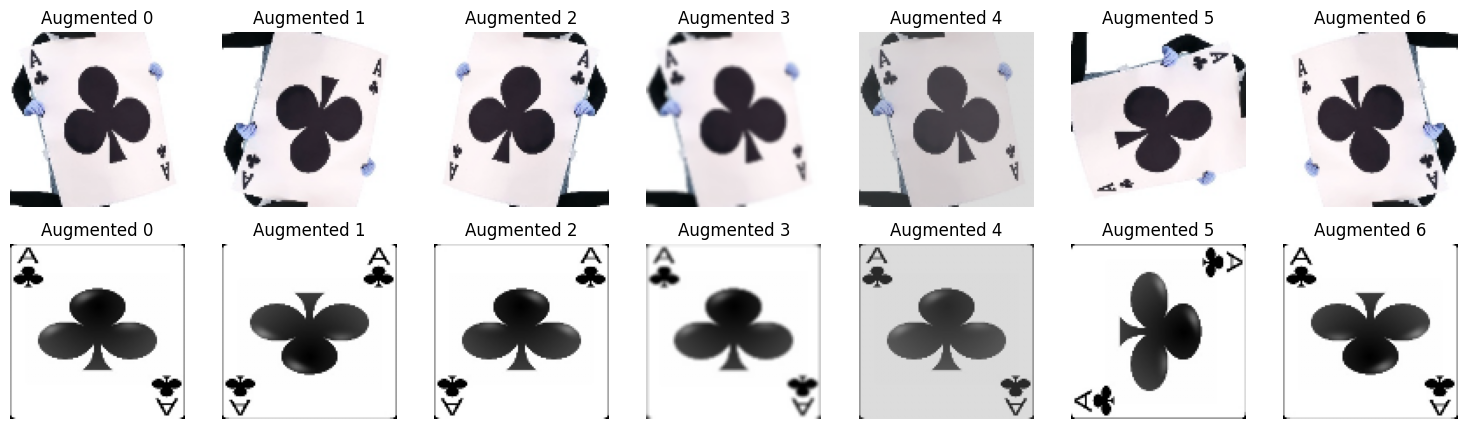

(43094, 100, 100, 3)
(43094,)


In [60]:
def augment(cod: int, image):
    if cod == 0: return image
    if cod == 1: return cv2.flip(image, 0)
    if cod == 2: return cv2.flip(image, 1)
    if cod == 3: return cv2.GaussianBlur(image, (3,3), 0)
    if cod == 4: return cv2.convertScaleAbs(image, alpha=180, beta=40) / 255
    if cod == 5: return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    if cod == 6: return cv2.rotate(image, cv2.ROTATE_180)
    
x_train = []
y_train = []
tmp = 0
s = 100
lst = [0] * 53
print(lst)
plt.figure(figsize=(15, 15))
for i in range(len(p)):
    img = p.iloc[i]['image'] # get the image name from image column in the ith row from the csv file
    image = cv2.imread(os.path.join('C:/Users/Sigma/archive/train/',img)) # read the image
    image_resize = cv2.resize(image, (s,s)) # resize it to be 100 * 100 *3
    image = image_resize / 255.0 # normalize the image
    for j in range(0, 7):
        if lst[code[p.iloc[i]['label']]] < 800 or j == 0:
            tmp_image = augment(j, image)
            x_train.append(list(tmp_image))
            y_train.append(code[p.iloc[i]['label']])
            if tmp < 2:
                  plt.subplot(7,7, 7*tmp + j+1)
                  plt.imshow(tmp_image)
                  plt.title(f'Augmented {j}')
                  plt.axis('off')
            lst[code[p.iloc[i]['label']]]+=1
    
    tmp += 1
plt.tight_layout()
plt.show()

# # return x,y from list to array
x_train= np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

{0: 791, 30: 836, 31: 828, 1: 812, 3: 860, 42: 818, 2: 854, 10: 805, 4: 805, 11: 832, 5: 821, 6: 818, 20: 770, 7: 808, 8: 818, 9: 815, 44: 834, 12: 825, 15: 814, 50: 807, 21: 810, 13: 714, 29: 839, 14: 820, 23: 806, 16: 853, 35: 815, 17: 834, 18: 845, 32: 842, 19: 851, 22: 811, 24: 836, 25: 784, 26: 791, 27: 809, 28: 828, 33: 700, 34: 770, 36: 844, 41: 815, 37: 821, 39: 800, 38: 807, 43: 810, 40: 833, 45: 770, 47: 756, 46: 821, 51: 829, 48: 818, 49: 808, 52: 833}


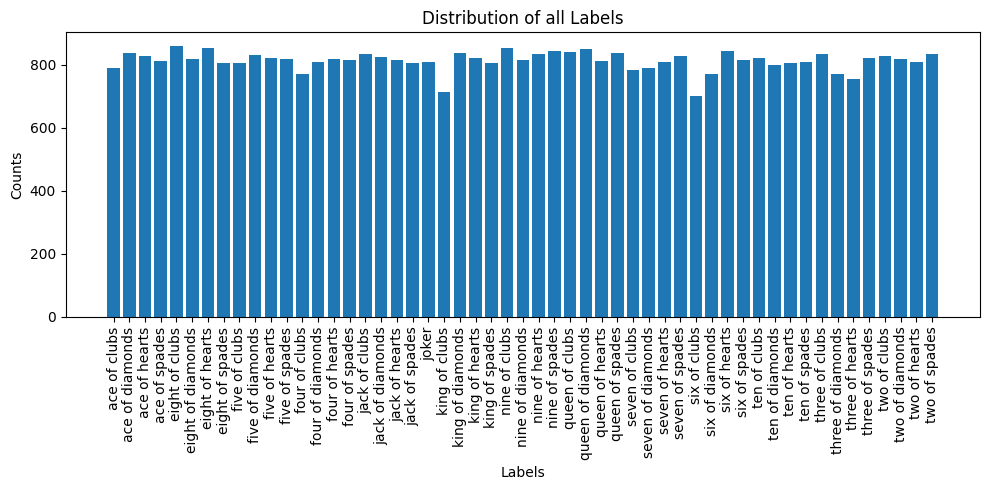

In [61]:
label_counts = {}
for label in y_train:
    if label in label_counts: label_counts[label] += 1
    else: label_counts[label] = 1
print(label_counts)
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(categorys, counts)
plt.title('Distribution of all Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation = 90)  
plt.tight_layout()
plt.show()

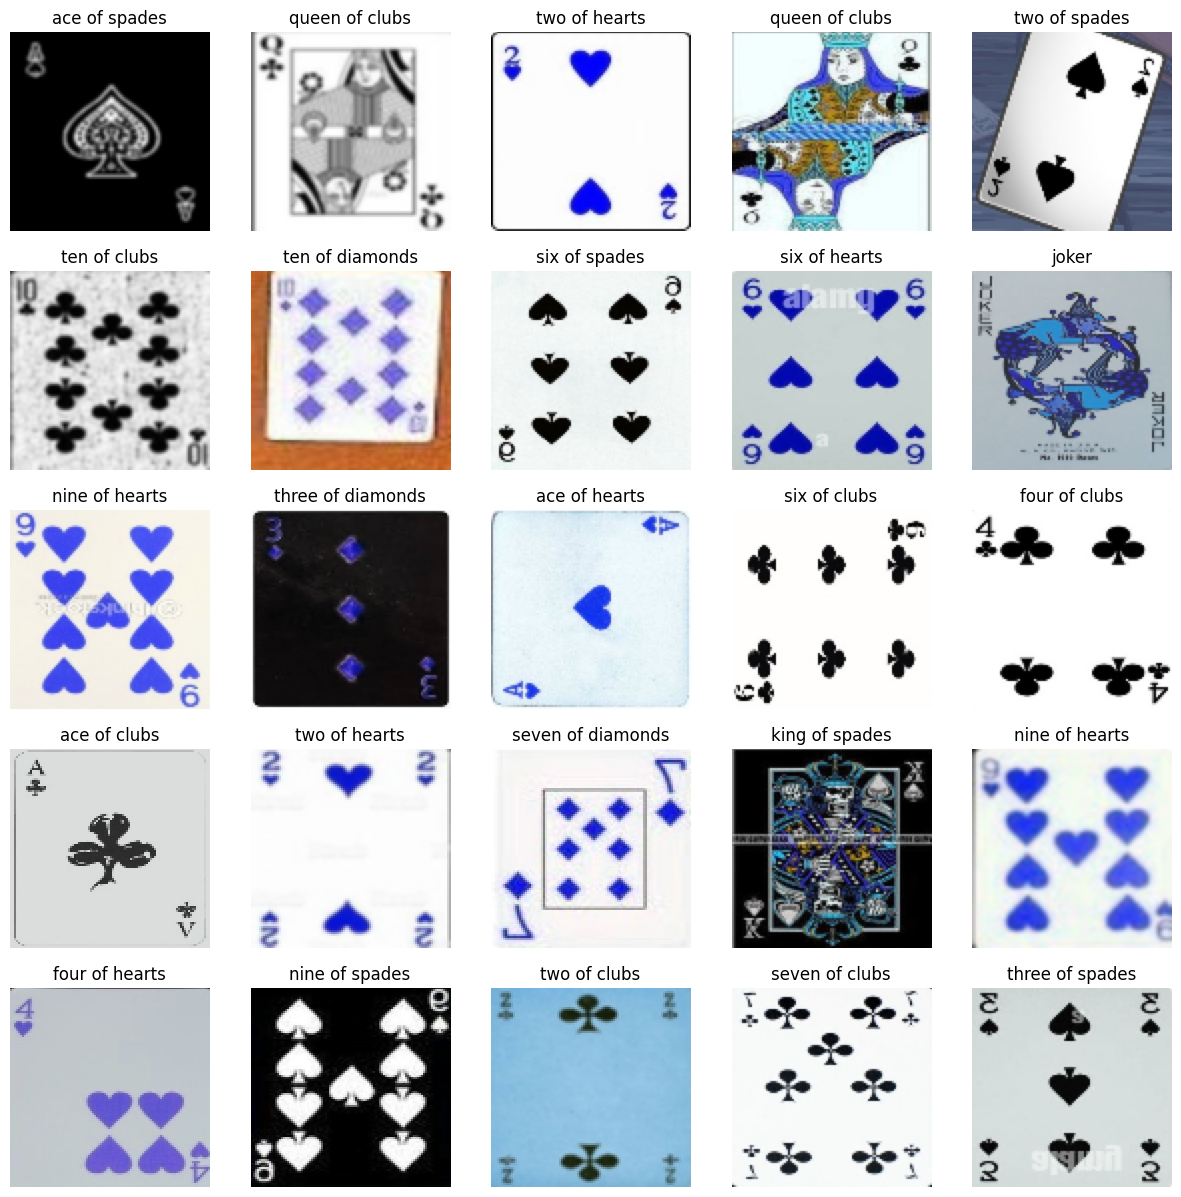

In [63]:
plt.figure(figsize=(15, 15))
for n, i in enumerate(list(np.random.randint(0, len(x_train), 25))):
    plt.subplot(5, 5, n+1)
    plt.imshow(x_train[i])
    plt.axis('off')
    plt.title(get_category[y_train[i]])

# Model Building

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from keras.models import Model

input_shape = (s,s,3)
model = Sequential([
tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape, padding="same"),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding="same"),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding="same"),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding="same"),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1536, activation='relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(53, activation='softmax')
])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
Path = 'best_model3_weights.weights.h5'
chk_pont = ModelCheckpoint(filepath = Path, monitor = 'val_accuracy', save_best_only = True, save_weights_only = True, mode = 'max', verbose =1)
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=10,verbose=1)

In [74]:
model2 = Sequential([
tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape,padding="same"),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding="same"),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding="same"),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding="same"),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1536, activation='relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(53, activation='softmax')
])
Path2 = 'best_model_weights.weights.h5'
Path3 = 'best_model2_weights.weights.h5'
chk_pont2 = ModelCheckpoint(filepath = Path2, monitor = 'val_loss', save_best_only = True, save_weights_only = True, mode = 'min', verbose =1)
chk_pont3 = ModelCheckpoint(filepath = Path3, monitor = 'val_accuracy', save_best_only = True, save_weights_only = True, mode = 'max', verbose =1)
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=10,verbose=1)

In [93]:
model.compile(optimizer ='Adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [76]:
model2.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1536)           │     7,079,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 53)             │        81,461 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,421,045 (28.31 MB)

 Trainable params: 7,421,045 (28.31 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
x_valid = []
y_valid = []
s = 100
data2 = "archive/valid"
for category in categorys:
    path2 = os.path.join(data2, category)
    for img in os.listdir(path2):
        image = cv2.imread(os.path.join(path2,img))
        image_resize = cv2.resize(image, (s,s))
        image_normalization= image_resize / 255.0
        x_valid.append(list(image_normalization))
        y_valid.append(code[category])

# return x,y from list to array
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

print(x_valid.shape)
print(y_valid.shape)

(265, 100, 100, 3)
(265,)


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from scikeras.wrappers import KerasClassifier
def create_model():
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=input_shape, padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3,3), activation='relu', padding="same"),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding="same"),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding="same"),
        MaxPooling2D(2,2),
        Flatten(),
        Dropout(0.5),
        Dense(1536, activation='relu'),
        Dropout(0.3),
        Dense(53, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)
batch_size = [16, 32, 64, 128, 256]
epochs = [5, 10, 15, 20, 25, 30]
param_grid = dict(batch_size=batch_size, epochs=epochs)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='accuracy')
grid_result = grid.fit(x, y)
best_params = grid_result.best_params_
best_score = grid_result.best_score_
print(best_params)

In [94]:
model1 = model.fit(x, y, epochs=30, batch_size=64,  validation_data=(x_valid, y_valid), callbacks=[early_stopping_2, chk_pont])

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.1038 - loss: 3.5383
Epoch 1: val_accuracy improved from -inf to 0.42264, saving model to best_model3_weights.weights.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - accuracy: 0.1046 - loss: 3.5340 - val_accuracy: 0.4226 - val_loss: 1.8079
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4100 - loss: 2.0270
Epoch 2: val_accuracy improved from 0.42264 to 0.63396, saving model to best_model3_weights.weights.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 334ms/step - accuracy: 0.4103 - loss: 2.0262 - val_accuracy: 0.6340 - val_loss: 1.1770
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5845 - loss: 1.5217
Epoch 3: val_accuracy improved from 0.63396 to 0.76981, saving model to best_model3_weights.weights.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.5846 - loss: 1.5212 - val_accuracy: 0.7698 - val_loss: 0.8834
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.66

In [79]:
model3 = model2.fit(x_train, y_train, epochs=30, batch_size=64,  validation_data=(x_valid, y_valid), callbacks=[early_stopping_2, chk_pont2,chk_pont3])

Epoch 1/30
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.3182 - loss: 2.4749
Epoch 1: val_loss improved from inf to 0.73122, saving model to best_model_weights.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to best_model2_weights.weights.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 254s 372ms/step - accuracy: 0.3184 - loss: 2.4739 - val_accuracy: 0.8000 - val_loss: 0.7312
Epoch 2/30
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7312 - loss: 0.9174
Epoch 2: val_loss improved from 0.73122 to 0.60538, saving model to best_model_weights.weights.h5

Epoch 2: val_accuracy improved from 0.80000 to 0.82264, saving model to best_model2_weights.weights.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 254s 377ms/step - accuracy: 0.7312 - loss: 0.9173 - val_accuracy: 0.8226 - val_loss: 0.6054
Epoch 3/30
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8244 - loss: 0.5781
Epoch 3: val_loss improved from 0.60538 to 0.56292, saving model to best_model_weights.weights.h5

In [36]:
train_accuracy = model1.history['val_loss']
print("Train Accuracy:", train_accuracy)

Train Accuracy: [0.5244807004928589, 0.5016775131225586, 0.44787269830703735, 0.5590265393257141, 0.49640342593193054, 0.4293036162853241, 0.4705020487308502, 0.4185830056667328, 0.4338466227054596, 0.4798469841480255]


In [179]:
model1.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

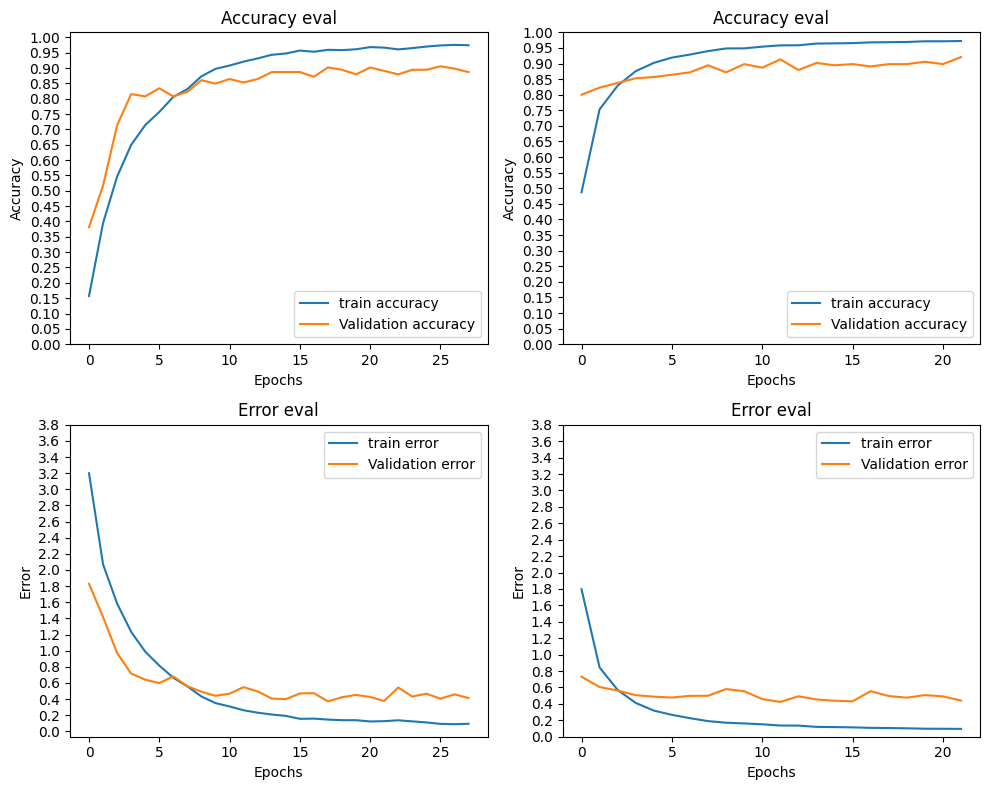

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0][0].plot(model1.history["accuracy"], label = "train accuracy")
axs[0][0].plot(model1.history["val_accuracy"], label = "Validation accuracy")
axs[0][0].set_ylabel("Accuracy")
axs[0][0].legend(loc = "lower right")
axs[0][0].set_xlabel("Epochs")
axs[0][0].set_title("Accuracy eval")
axs[0][0].set_yticks([i / 20 for i in range(21)])

axs[0][1].plot(model3.history["accuracy"], label = "train accuracy")
axs[0][1].plot(model3.history["val_accuracy"], label = "Validation accuracy")
axs[0][1].set_ylabel("Accuracy")
axs[0][1].legend(loc = "lower right")
axs[0][1].set_xlabel("Epochs")
axs[0][1].set_title("Accuracy eval")
axs[0][1].set_yticks([i / 20 for i in range(21)])

axs[1][0].plot(model1.history["loss"], label = "train error")
axs[1][0].plot(model1.history["val_loss"], label = "Validation error")
axs[1][0].set_ylabel("Error")
axs[1][0].set_xlabel("Epochs")
axs[1][0].legend(loc = "upper right")
axs[1][0].set_title("Error eval")
axs[1][0].set_yticks(np.arange(0, 3+1, 0.2))

axs[1][1].plot(model3.history["loss"], label = "train error")
axs[1][1].plot(model3.history["val_loss"], label = "Validation error")
axs[1][1].set_ylabel("Error")
axs[1][1].set_xlabel("Epochs")
axs[1][1].legend(loc = "upper right")
axs[1][1].set_title("Error eval")
axs[1][1].set_yticks(np.arange(0, 3+1, 0.2))
plt.tight_layout()
plt.show()

In [35]:
x_test = []
y_test = []
s = 100
data2 = "archive/test"
for category in categorys:
    path2 = os.path.join(data2, category)
    for img in os.listdir(path2):
        image = cv2.imread(os.path.join(path2,img))
        image_resize = cv2.resize(image, (s,s))
        image_normalization = image_resize / 255.0
        x_test.append(list(image_normalization))
        y_test.append(code[category])

# return x,y from list to array
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_test.shape)
print(y_test.shape)

(265, 100, 100, 3)
(265,)


In [98]:
model.load_weights(Path)
# model.save('C:\\Users\\Sigma\\archive\\model3.keras')
# x_model2 = model2
# x_model22 = model3
ModelLoss, ModelAccuracy = model.evaluate(x_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9192 - loss: 0.4369
Test Loss is 0.5880295038223267
Test Accuracy is 0.8943396210670471


In [108]:
model2.load_weights('best_model5_weights.weights.h5')
# model2.save('C:\\Users\\Sigma\\archive\\model2.keras')
# x_model2 = model2
# x_model22 = model3
ModelLoss3, ModelAccuracy3 = model2.evaluate(x_test, y_test)

print('Test Loss is {}'.format(ModelLoss3))
print('Test Accuracy is {}'.format(ModelAccuracy3 ))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9219 - loss: 0.4851
Test Loss is 0.6990696787834167
Test Accuracy is 0.8905660510063171


In [31]:
ModelLoss2, ModelAccuracy2 = model2.evaluate(x_test, y_test)

print('Test Loss is {}'.format(ModelLoss2))
print('Test Accuracy is {}'.format(ModelAccuracy2 *100))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9301 - loss: 0.4218
Test Loss is 0.6156798005104065
Test Accuracy is 90.56603908538818


In [88]:
model = keras.models.load_model('C:\\Users\\Sigma\\archive\\model.h5')

* Model Evaluation Scores

In [99]:
y_pred=model.predict(x_test)
pred_lbls=[np.argmax(lbl) for lbl in y_pred ]
pred_lbls=np.array(pred_lbls)
pred_lbls

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8, 37,  8,  8,  9,  9,  9,  9, 13, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11,  4, 12, 12, 37, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 43, 15, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 30, 17, 17, 18, 23, 18, 18, 18, 19, 19, 24, 19, 19, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23, 24, 24, 24, 21, 24, 25,  8, 25, 25, 25, 26, 26, 26, 26, 26, 27,
       27, 27, 39, 27, 44, 28, 44, 28, 28, 29, 29, 29, 32, 29, 30, 30, 30,
       30, 30, 31, 31, 31, 30, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
       34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 29,  0,
       37, 37, 25, 38, 38, 38, 38, 38, 43, 39, 39, 39, 39, 40, 40, 40, 40,
       40, 41, 41, 41, 41, 41, 42,  5, 42, 42, 42, 43, 27, 43, 43, 43, 44,
       44, 44, 40, 44, 45

In [100]:
y_pred2=model2.predict(x_test)
pred_lbls2=[np.argmax(lbl) for lbl in y_pred2 ]
pred_lbls2=np.array(pred_lbls2)
pred_lbls2

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8, 12,  8,  8,  9,  9,  9,  9, 26, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 43, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 19, 16, 16, 16,
       17, 17, 26, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20,
       20, 19, 20, 21, 21, 21, 21, 21, 22, 22, 22, 23, 22, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 25,  8, 25, 25, 25, 26, 26, 26, 26, 26, 27,
       27, 27, 51, 27, 44, 28, 44, 28, 28, 29, 29, 29, 16, 29, 30, 30, 30,
       38, 30, 31, 31, 31, 30, 31, 32, 32, 32, 24, 32, 33, 33, 33, 33, 33,
       34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 34, 36, 31,  0,
       37, 37,  0, 38, 38, 38, 38, 38, 27, 39, 39, 39, 39, 40, 40, 40, 40,
       40, 41, 41, 41, 41, 41, 42,  5, 42, 42, 42, 43, 27, 43, 43, 43, 44,
       44, 44, 19, 44, 45

In [101]:

# Calculate Precision score
precision=precision_score(y_test,pred_lbls,average="macro")
print("Precision = {}".format(precision))

# Calculate Recall Score
recall=recall_score(y_test,pred_lbls,average="macro")
print("Recall = {}".format(recall))

# Calculate F1 score
f1 = f1_score(y_test, pred_lbls, average='macro')
print("F1 Score = {}".format(f1))

Precision = 0.9055705300988319
Recall = 0.8943396226415095
F1 Score = 0.8924337716790546


In [102]:

# Calculate Precision score
precision=precision_score(y_test,pred_lbls2,average="macro")
print("Precision = {}".format(precision))

# Calculate Recall Score
recall=recall_score(y_test,pred_lbls2,average="macro")
print("Recall = {}".format(recall))

# Calculate F1 score
f1 = f1_score(y_test, pred_lbls2, average='macro')
print("F1 Score = {}".format(f1))

Precision = 0.9120619946091643
Recall = 0.8867924528301886
F1 Score = 0.8868353868353867


* Confusion Matrix & HeatMap

In [103]:
Cm = confusion_matrix(y_test,pred_lbls)
Cm

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 3]], dtype=int64)

In [104]:
Cm2 = confusion_matrix(y_test,pred_lbls2)
Cm2

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 3]], dtype=int64)

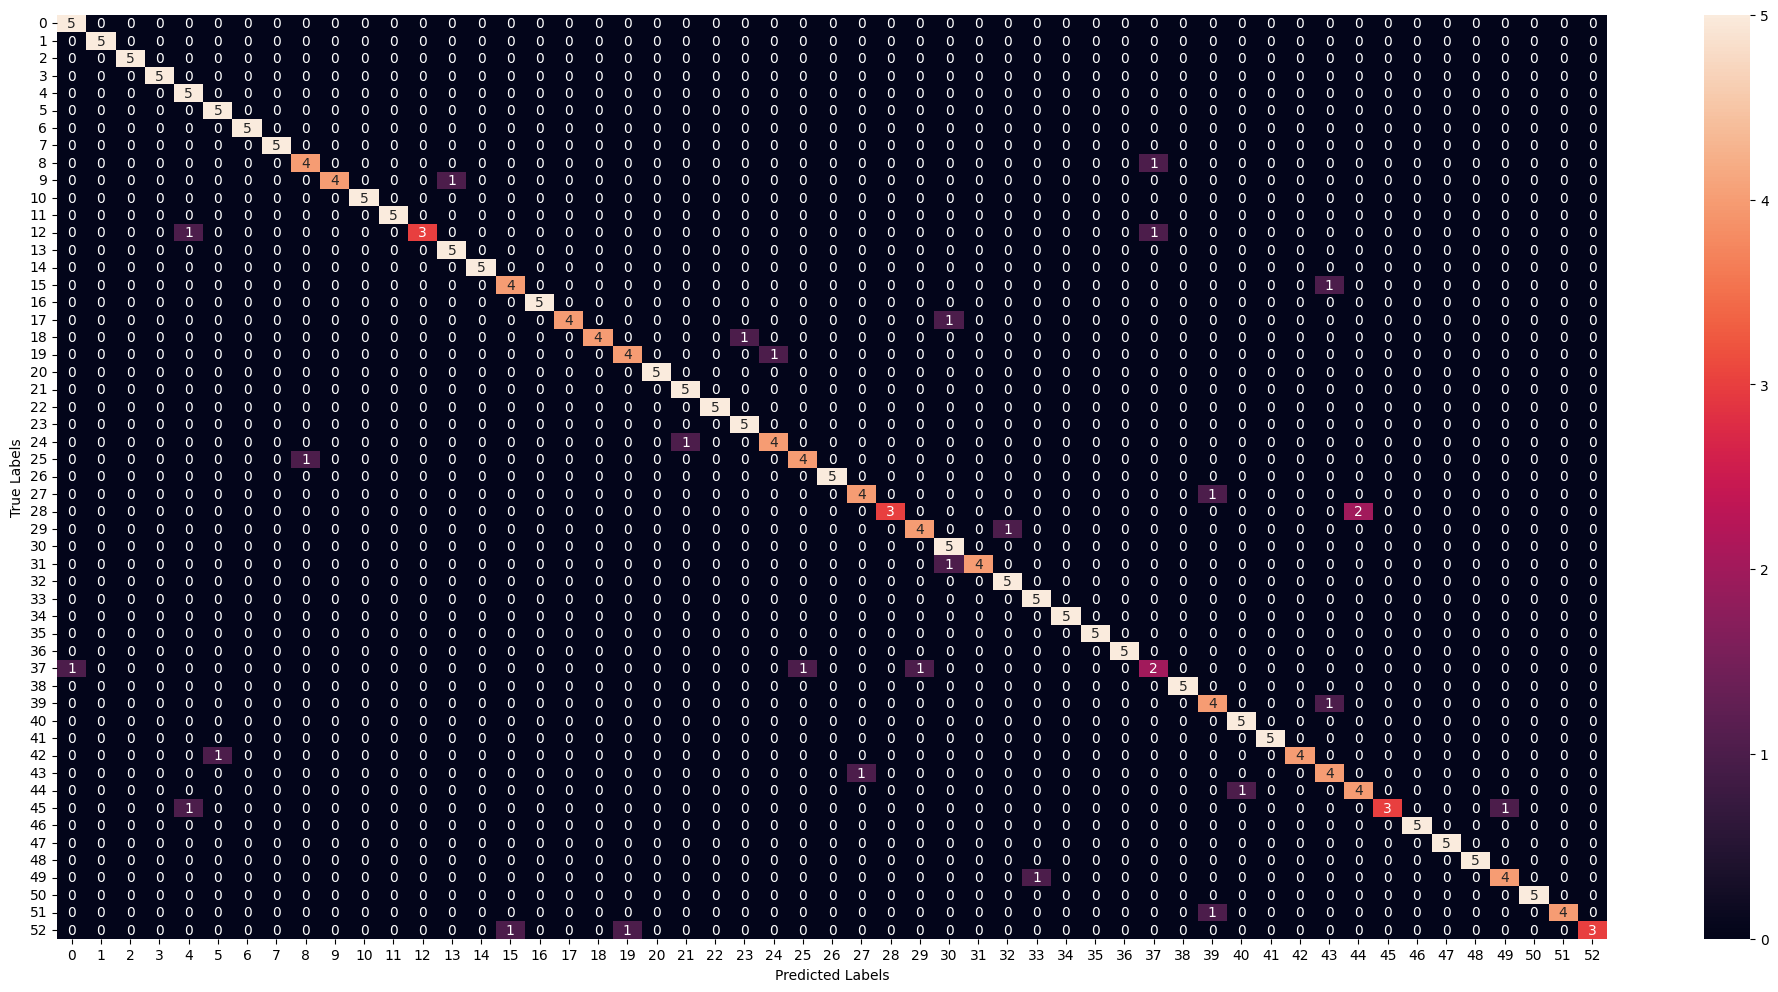

In [105]:
# x axis : predicted
# y axis : true

#Heat_Map
plt.figure(figsize=(25, 12))
sns.heatmap(Cm ,annot =True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

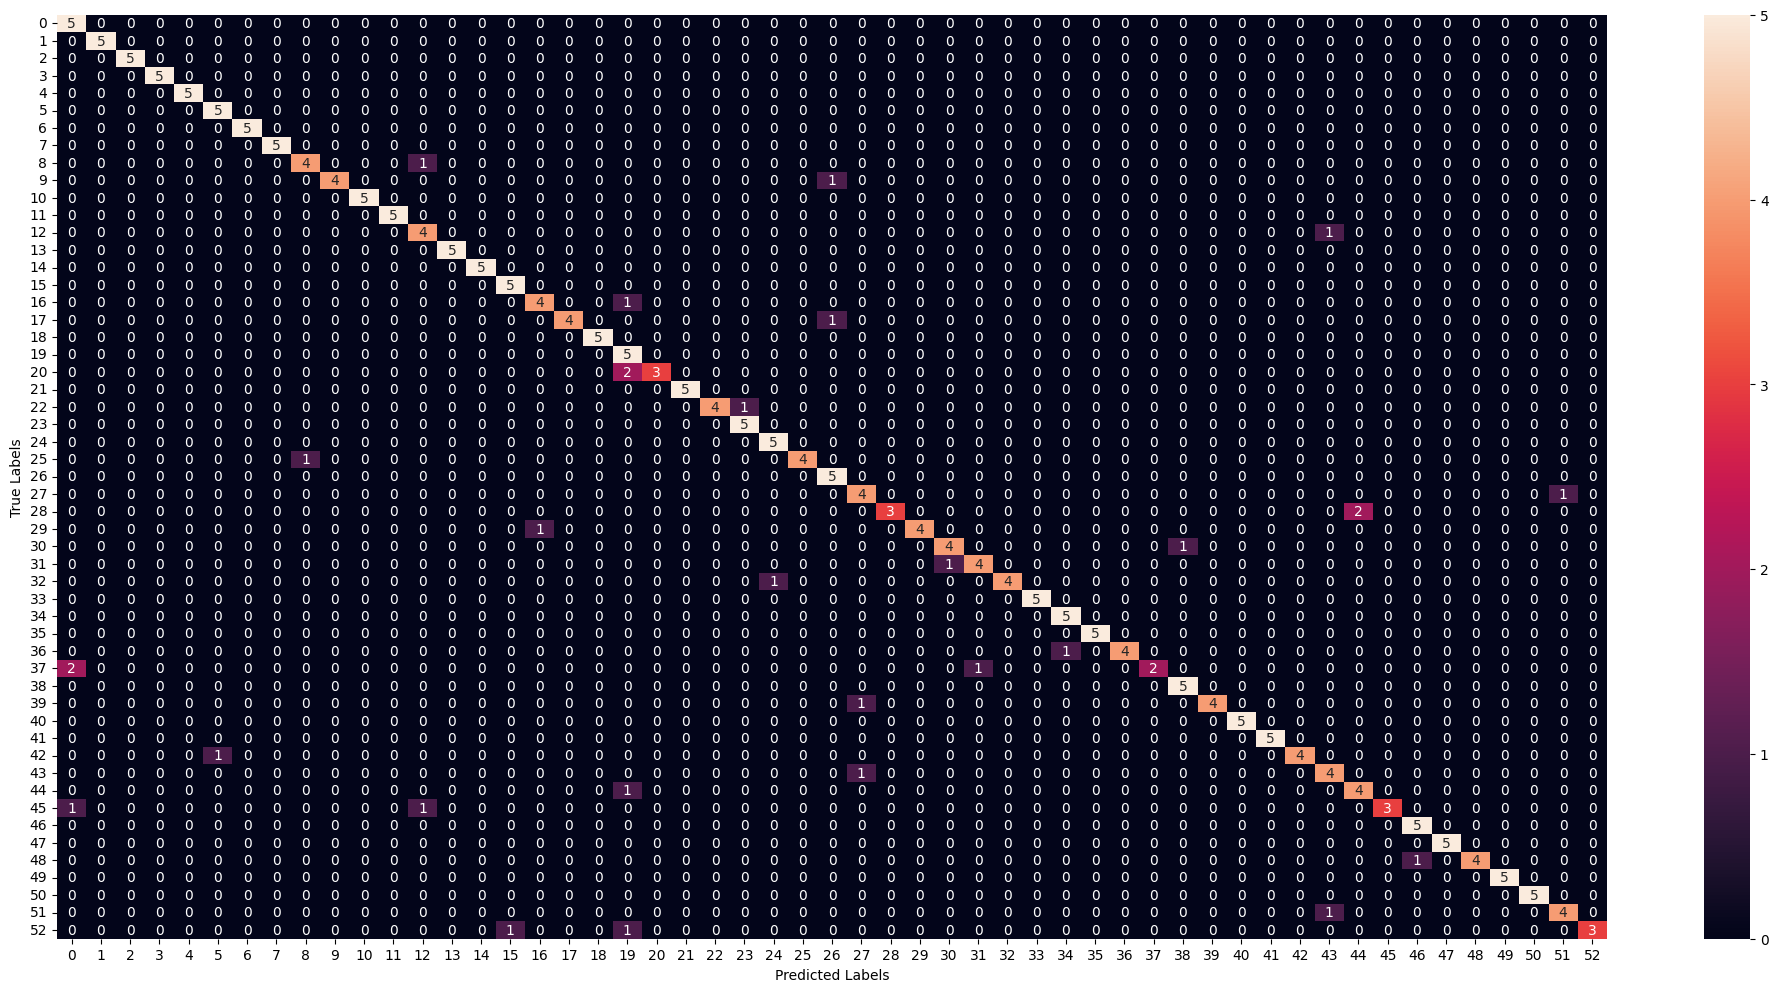

In [106]:
plt.figure(figsize=(25, 12))
sns.heatmap(Cm2 ,annot =True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

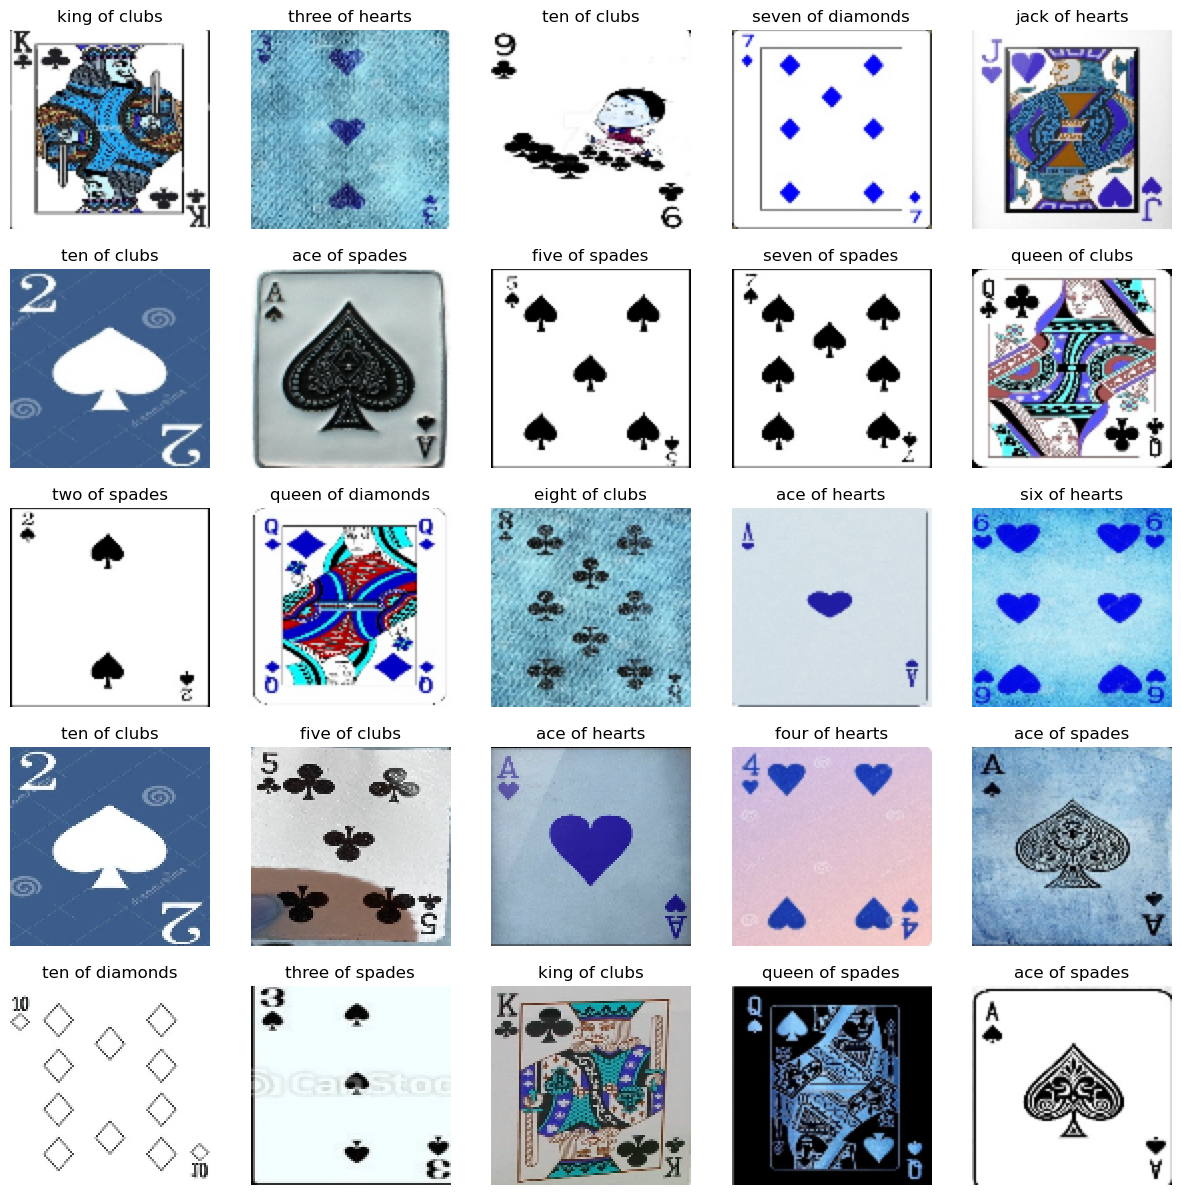

In [188]:
plt.figure(figsize=(15, 15))
for n, i in enumerate(list(np.random.randint(0, len(x_test), 25))):
    plt.subplot(5, 5, n+1)
    plt.imshow(x_test[i])
    # plt.xlabel(y_test[i])
    plt.axis('off')
    plt.title(get_category[pred_lbls[i]])